<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from itertools import chain

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 19, subsample = 0.7, verbosity = 0)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (10,) * 3
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='logistic',
                                solver='adam', learning_rate='invscaling', max_iter=1000)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return dnn, ttimes

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=21, p=2, n_neighbors=4)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes

In [7]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [8]:
windowrange=[3, 5, 10, 30, 75, 150, 300]
samplingrange=[1, 2, 3, 5, 10]

A_XGB = np.zeros([len(samplingrange),len(windowrange)])
GP_XGB = np.zeros([len(samplingrange),len(windowrange)])
GR_XGB = np.zeros([len(samplingrange),len(windowrange)])
GF1_XGB = np.zeros([len(samplingrange),len(windowrange)])

A_DNN = np.zeros([len(samplingrange),len(windowrange)])
GP_DNN = np.zeros([len(samplingrange),len(windowrange)])
GR_DNN = np.zeros([len(samplingrange),len(windowrange)])
GF1_DNN = np.zeros([len(samplingrange),len(windowrange)])

A_KNN = np.zeros([len(samplingrange),len(windowrange)])
GP_KNN = np.zeros([len(samplingrange),len(windowrange)])
GR_KNN = np.zeros([len(samplingrange),len(windowrange)])
GF1_KNN = np.zeros([len(samplingrange),len(windowrange)])

def training_loop(windowrange, samplingrange):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xgb_all_ttimes = []
    dnn_all_ttimes = []
    knn_all_ttimes = []
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    spacing = 1
    
    for i, sampling in enumerate(samplingrange): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
            print('********************************')
            print('Iteration for spacing={}, window length={}, sampling length={}'.format(spacing, length, sampling))

            ####### 1) Load dataset #######
            print('1) Loading dataset into (XX,yy)...')

            XX = None
            yy = None
            folderpath='../Features_1_8'

            for filename in os.listdir(folderpath):
                if filename.endswith('_sa' + str(sampling)+'_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                    label = 0
                    if int(filename[9]) > 5:
                        label = 1
                    fullname = folderpath + '/' + filename
                    XX, yy = load_window_dataset(XX, yy, fullname, label)

            scaler = StandardScaler()
            XX = scaler.fit_transform(XX)

            X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)
            print('Training XGB...')
            xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)

            print('Training DNN...')
            dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)

            print('Training KNN...')
            knn, knn_ttimes = train_classifier_KNN(X_train, y_train)

            xgb_all_ttimes.append(xgb_ttimes)
            dnn_all_ttimes.append(dnn_ttimes)
            knn_all_ttimes.append(knn_ttimes)

            y_pred_XGB = xgb.predict(X_test)
            y_pred_DNN = dnn.predict(X_test)
            y_pred_KNN = knn.predict(X_test)

            A_XGB[i,j], GP_XGB[i,j], GR_XGB[i,j], GF1_XGB[i,j] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
            A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
            A_KNN[i,j], GP_KNN[i,j], GR_KNN[i,j], GF1_KNN[i,j] = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    return xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes

In [9]:
fig_folder = '1_8_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes = training_loop(windowrange, samplingrange)

********************************
Iteration for spacing=1, window length=3, sampling length=1
1) Loading dataset into (XX,yy)...
Training XGB...
22.791999578475952
24.791320085525513
25.24313998222351
Training DNN...
45.65550088882446
24.546263694763184
32.23603415489197
Training KNN...
0.13182640075683594
0.12013411521911621
0.13234758377075195
********************************
Iteration for spacing=1, window length=5, sampling length=1
1) Loading dataset into (XX,yy)...
Training XGB...
22.45344853401184
21.588469743728638
22.26803469657898
Training DNN...
33.27774906158447
34.45614290237427
27.70055365562439
Training KNN...
0.13148212432861328
0.11706733703613281
0.12791109085083008
********************************
Iteration for spacing=1, window length=10, sampling length=1
1) Loading dataset into (XX,yy)...
Training XGB...
14.912286043167114
15.483376741409302
15.00740098953247
Training DNN...
15.23285460472107
25.572842359542847
12.593531847000122
Training KNN...
0.10117149353027344

6.078913688659668
6.647244691848755
5.755173206329346
Training KNN...
0.024264812469482422
0.020999908447265625
0.019999980926513672
********************************
Iteration for spacing=1, window length=30, sampling length=5
1) Loading dataset into (XX,yy)...
Training XGB...
1.2178435325622559
1.2137291431427002
1.2433686256408691
Training DNN...
5.252619028091431
5.463281869888306
4.8373658657073975
Training KNN...
0.022005081176757812
0.023001909255981445
0.021000385284423828
********************************
Iteration for spacing=1, window length=75, sampling length=5
1) Loading dataset into (XX,yy)...
Training XGB...
1.0217013359069824
1.0375821590423584
1.0390045642852783
Training DNN...
5.586183547973633
6.584321737289429
5.094336032867432
Training KNN...
0.02225041389465332
0.02024245262145996
0.020003318786621094
********************************
Iteration for spacing=1, window length=150, sampling length=5
1) Loading dataset into (XX,yy)...
Training XGB...
0.9587998390197754
0

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xlabel('Window')
    ax.set_ylabel('Sampling')
    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


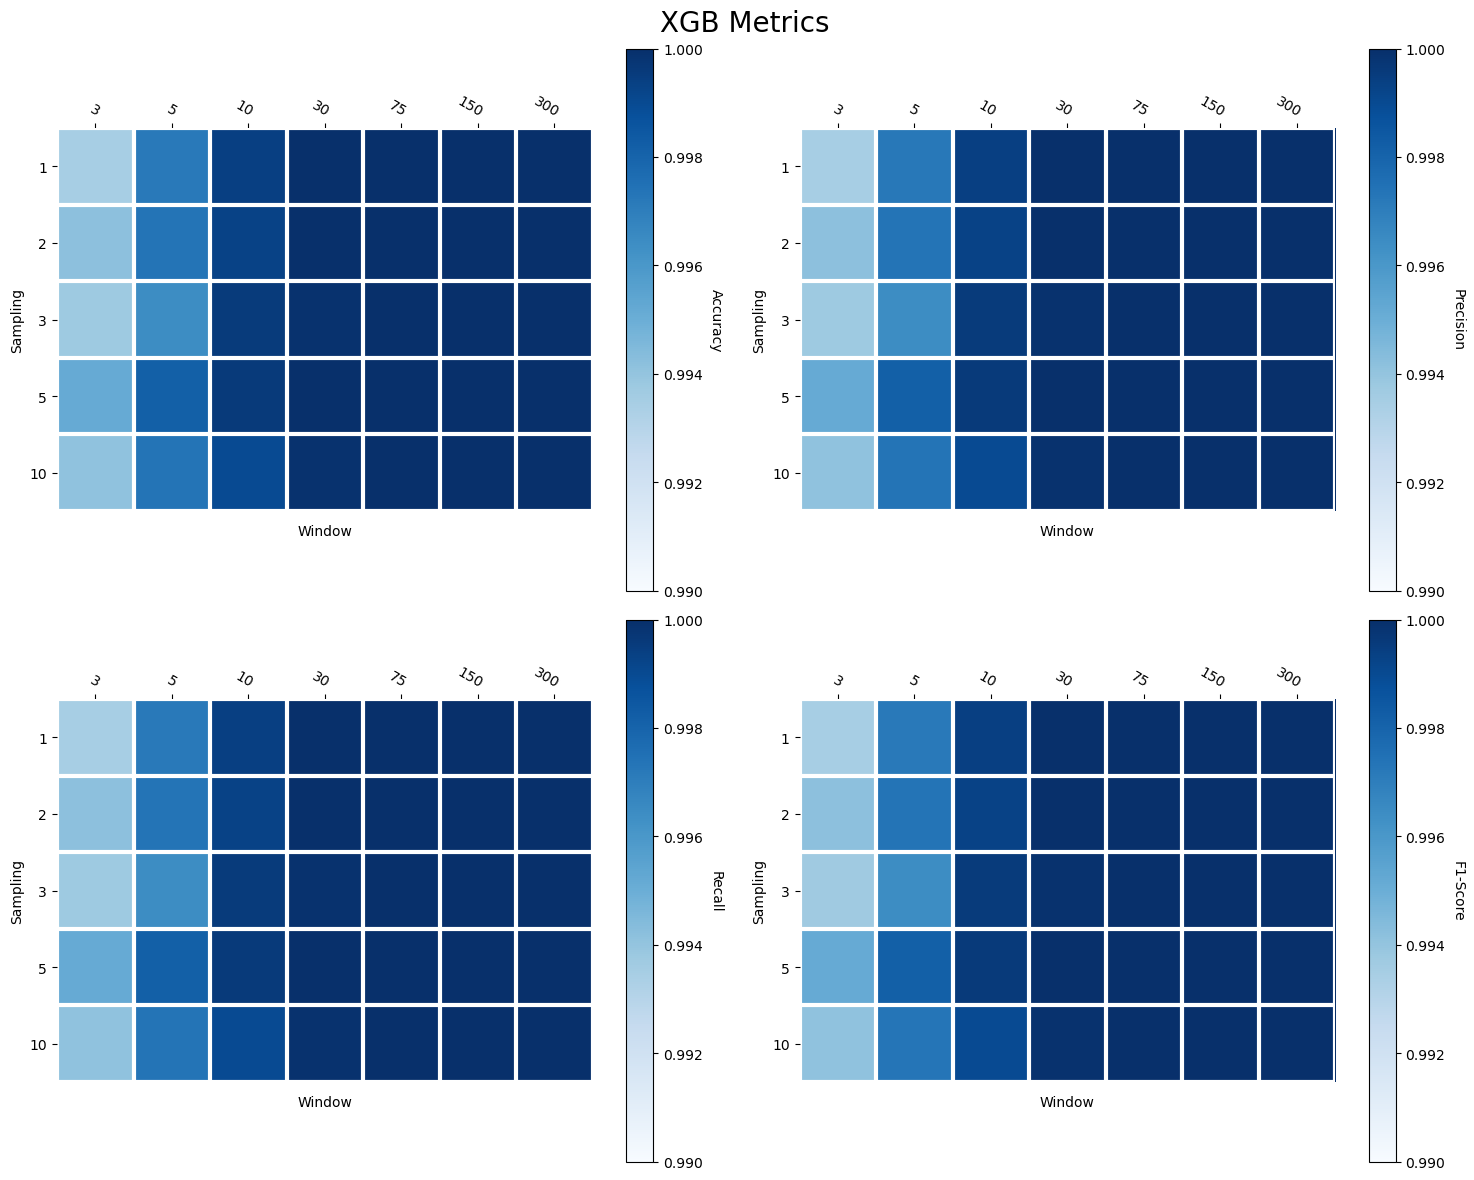

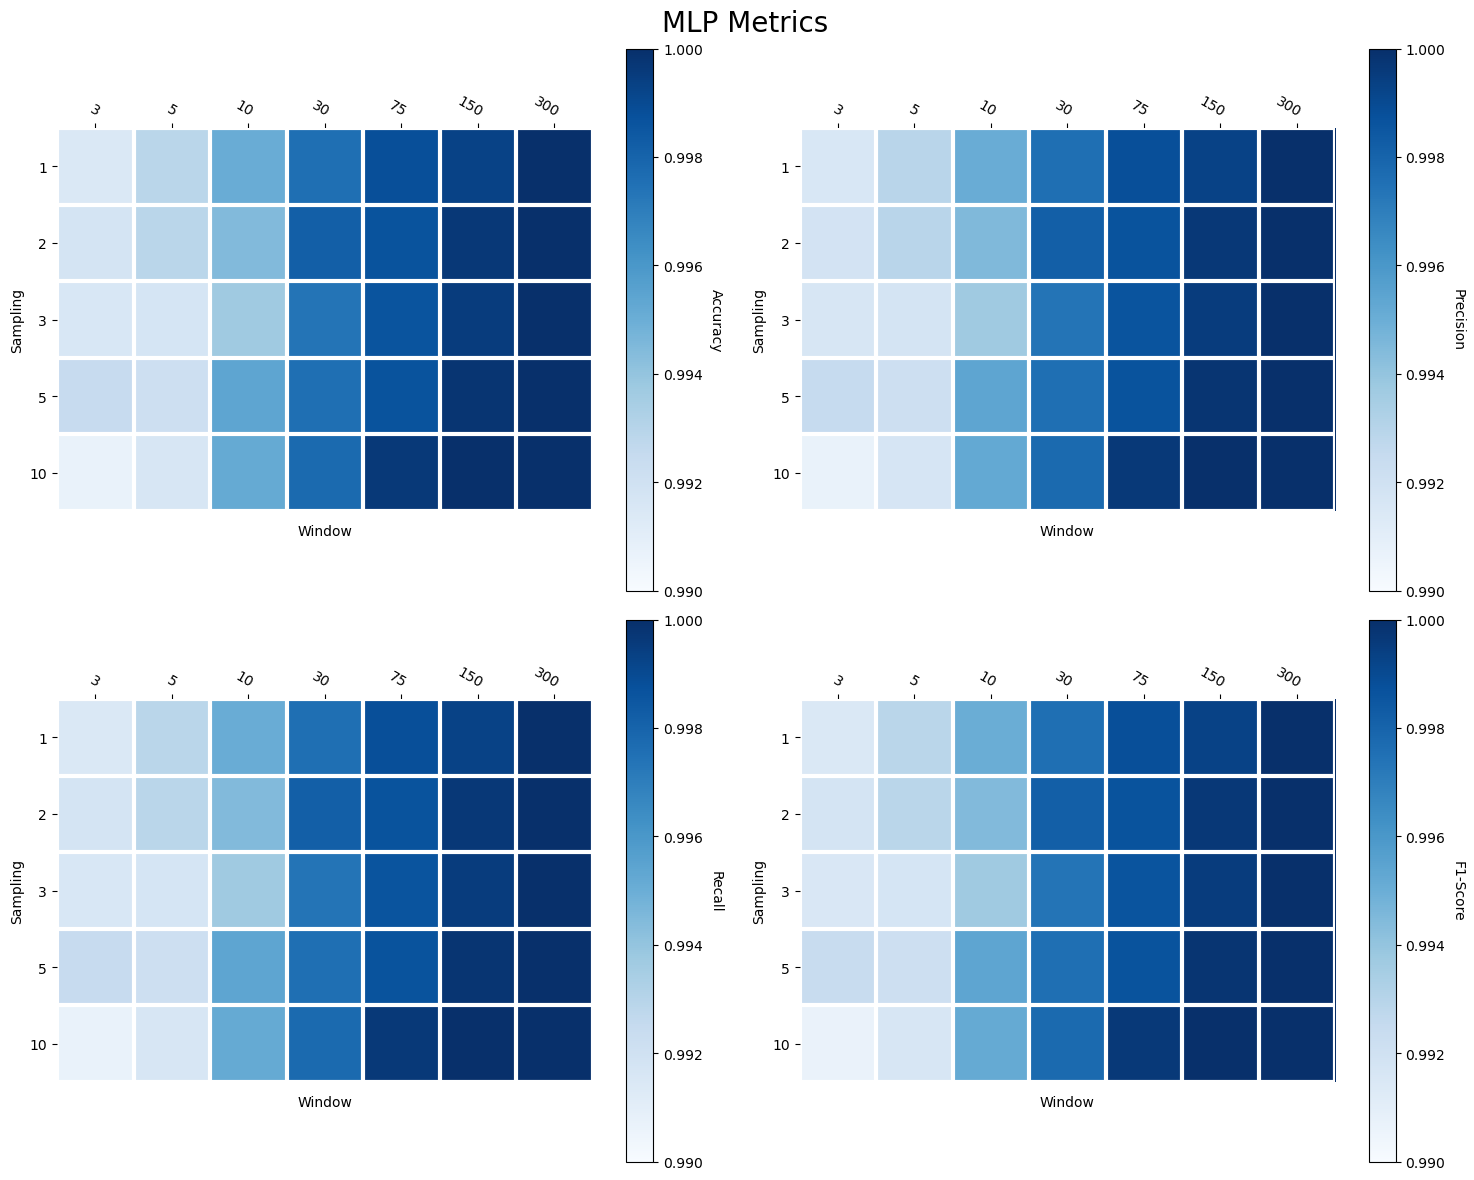

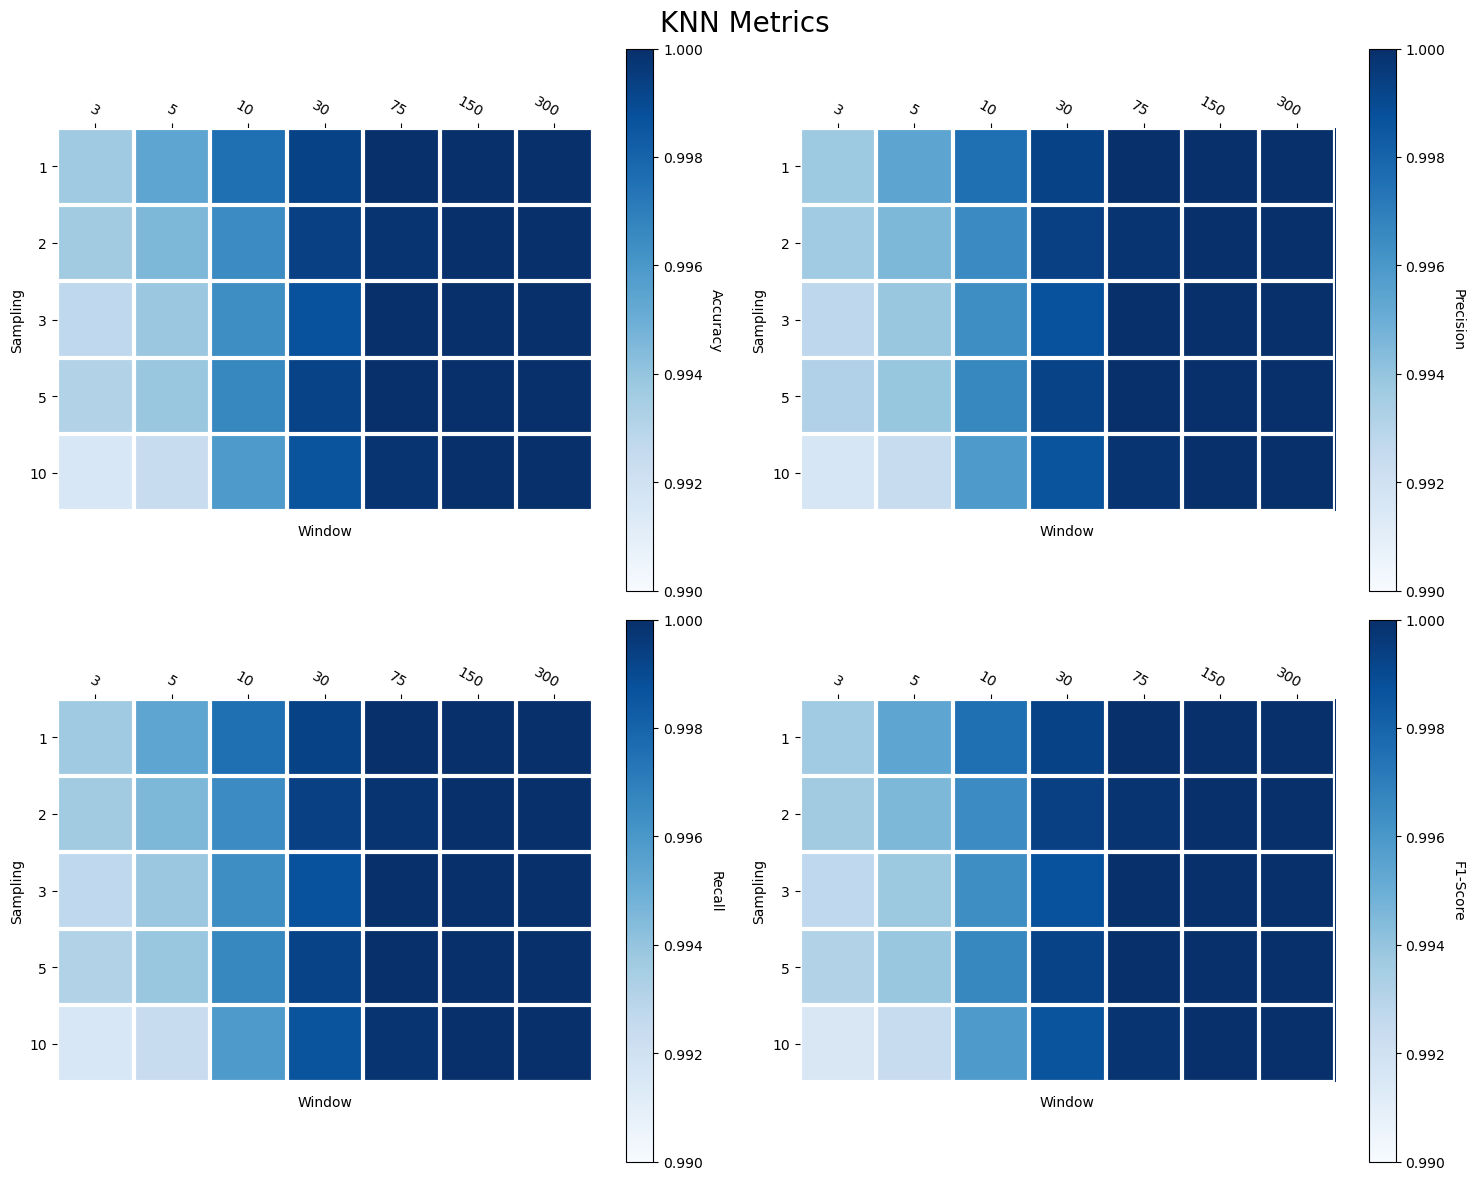

In [15]:
str_window_range = [str(x) for x in windowrange]
str_sampling_range = [str(x) for x in samplingrange]

alg_names = ['XGB', 'MLP', 'KNN']

A_mat = [A_XGB, A_DNN, A_KNN]
GP_mat = [GP_XGB, GP_DNN, GP_KNN]
GR_mat = [GR_XGB, GR_DNN, GR_KNN]
GF1_mat = [GF1_XGB, GF1_DNN, GF1_KNN]

for i in range(0, 3):
    fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,12))

    im, _ = heatmap(A_mat[i], str_sampling_range, str_window_range, ax=ax,
                    cmap="Blues", cbarlabel="Accuracy", vmin=0.99, vmax=1)

    im, _ = heatmap(GP_mat[i], str_sampling_range, str_window_range, ax=ax2,
                    cmap="Blues", cbarlabel="Precision", vmin=0.99, vmax=1)

    im, _ = heatmap(GR_mat[i], str_sampling_range, str_window_range, ax=ax3,
                    cmap="Blues", cbarlabel="Recall", vmin=0.99, vmax=1)

    im, _ = heatmap(GF1_mat[i], str_sampling_range, str_window_range, ax=ax4,
                    cmap="Blues", cbarlabel="F1-Score", vmin=0.99, vmax=1)

    title = alg_names[i] + " Metrics"
    fig.suptitle(title, fontsize=20)
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')
    plt.tight_layout()
    plt.show()

In [12]:
all_ttimes = [xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes]

xgb_all_ttimes_mean = []
dnn_all_ttimes_mean = []
knn_all_ttimes_mean = []
    
all_ttimes_mean = [xgb_all_ttimes_mean, dnn_all_ttimes_mean, knn_all_ttimes_mean]

for ttimes in xgb_all_ttimes:
    xgb_all_ttimes_mean.append(sum(ttimes)/len(ttimes))

for ttimes in dnn_all_ttimes:
    dnn_all_ttimes_mean.append(sum(ttimes)/len(ttimes))
    
for ttimes in knn_all_ttimes:
    knn_all_ttimes_mean.append(sum(ttimes)/len(ttimes))

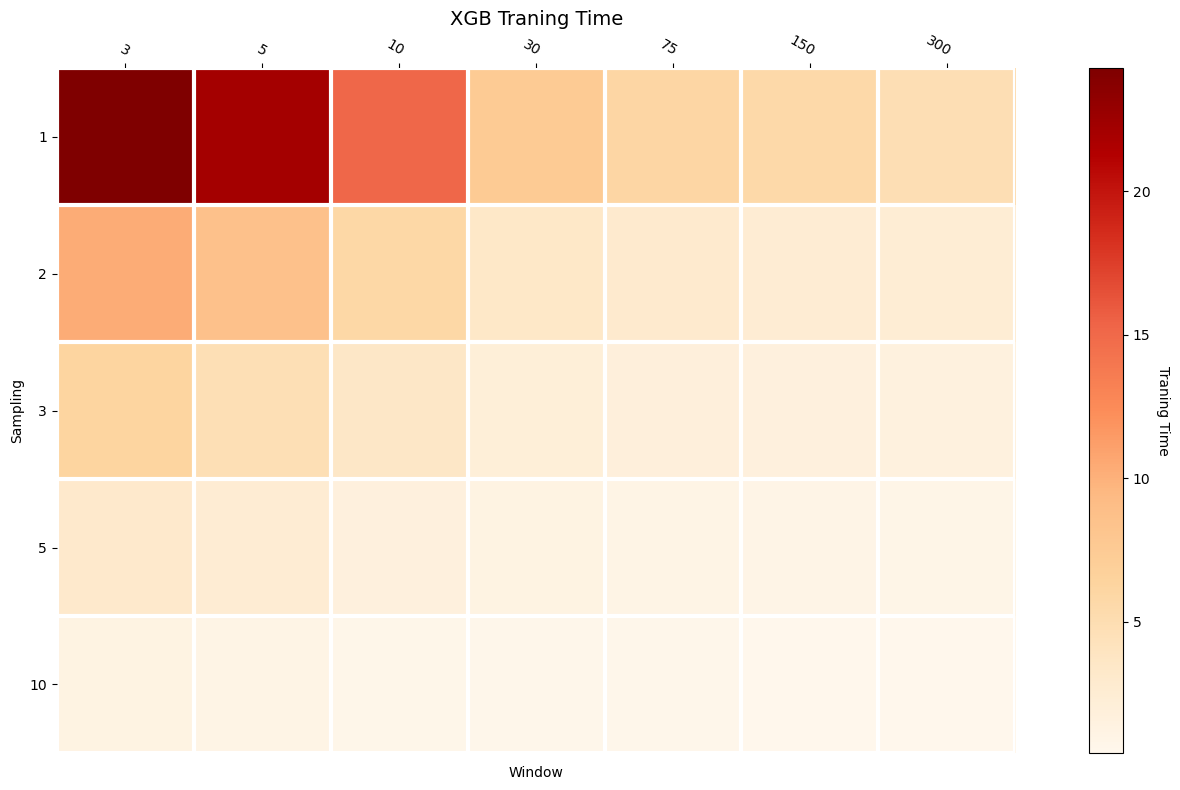

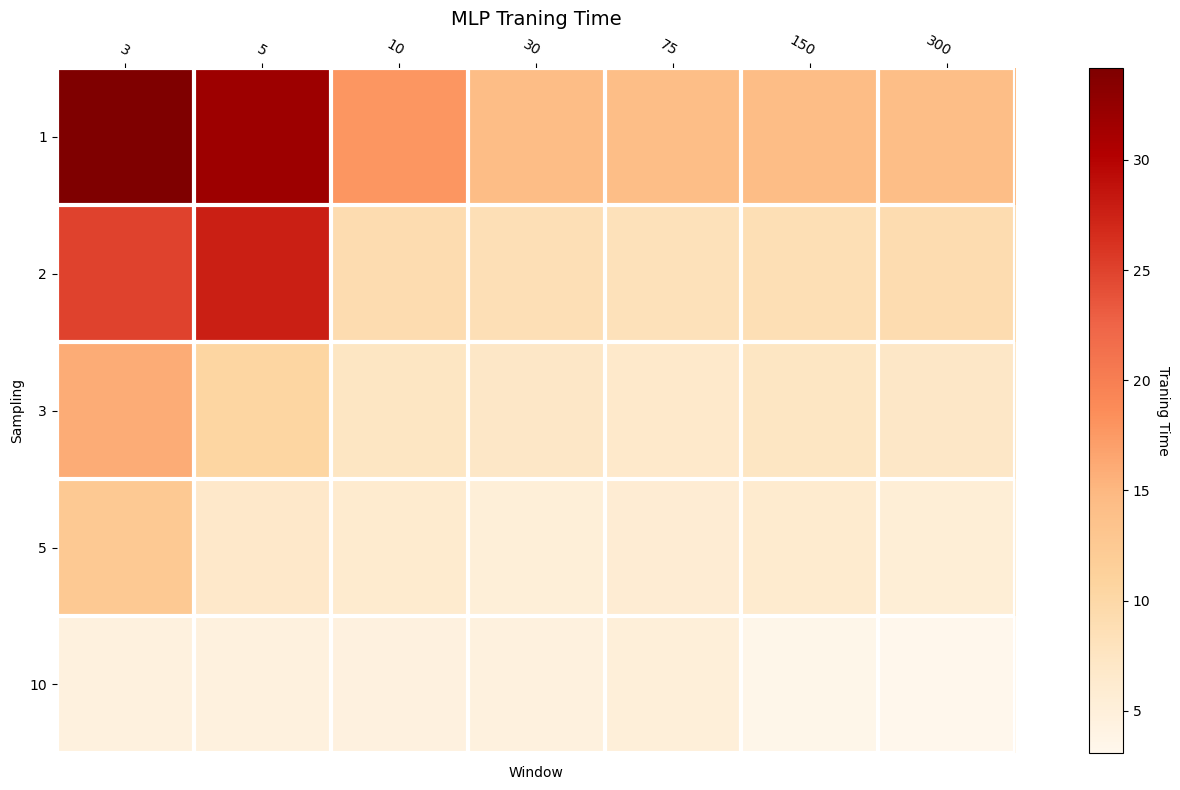

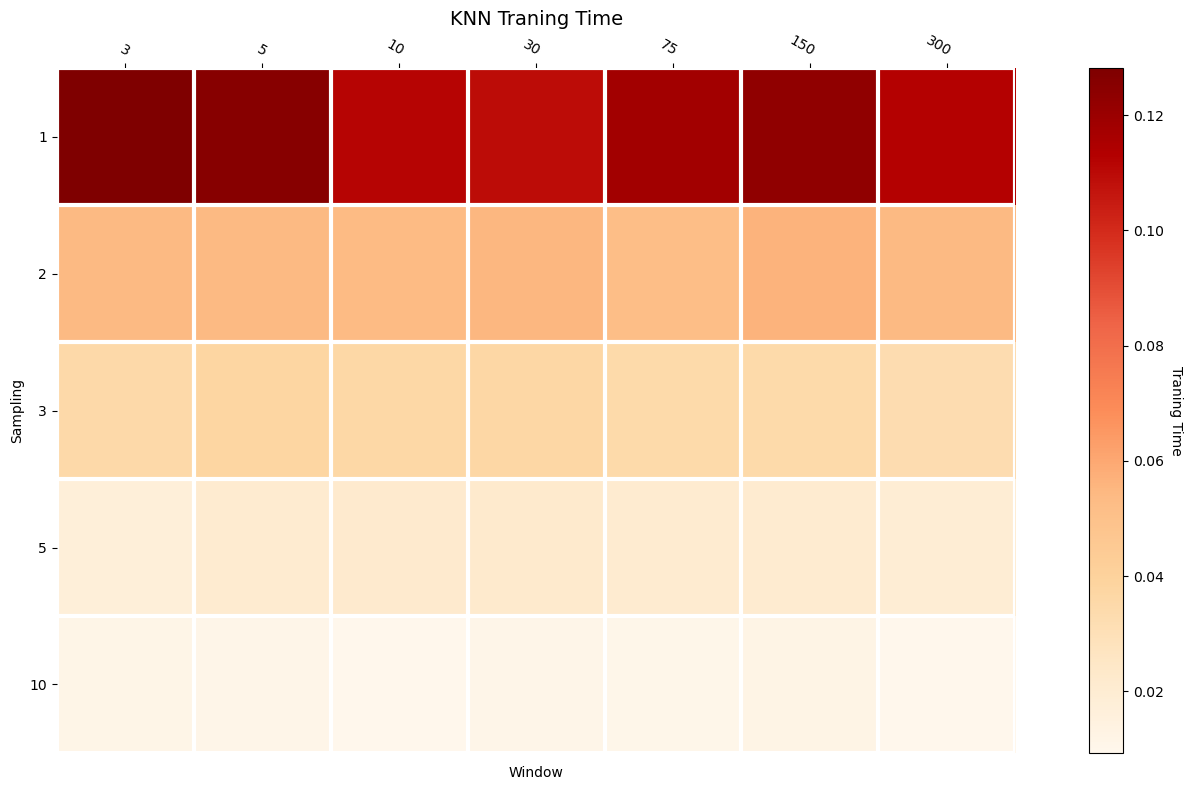

In [13]:
all_times_mat = []

for alg_all_ttimes in all_ttimes_mean:
    mat = []
    while alg_all_ttimes != []:
        mat.append(alg_all_ttimes[:len(windowrange)])
        alg_all_ttimes = alg_all_ttimes[len(windowrange):]
    mat = np.array(mat)
    all_times_mat.append(mat)

for i in range(0, 3):
    fig, ax = plt.subplots(figsize=(15,8))
    title = alg_names[i] + " Traning Time"
    im, cbar = heatmap(all_times_mat[i], str_sampling_range, str_window_range, ax=ax,
                       cmap="OrRd", cbarlabel="Traning Time")
    
    plt.title(title, fontsize=14)
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')                       
    plt.show()
